# Vacant Threshold test

In [1]:
import random
import numpy
from datetime import datetime
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import cv2 as cv


# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, row_name, process_batch=True):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=4, random_seed=random_seed)
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch()
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    metrics_provider.show_confusion_matrix(plot=True)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_threshold_list, vacant_threshold_list):
    detection_params.weather = weather
    metrics_dict_vt = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for diff_threshold in diff_threshold_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} diff_t={diff_threshold}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.diff_threshold = diff_threshold
            metrics = test_parking(parking_id, weather, detection_params, row_name)
            
            metrics_dict_diff[diff_threshold] = metrics

        metrics_dict_vt[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict_vt
    # PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)
        
def setup_params(parking_id, weather, initial_params:DetectionParams=None):
   
    provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=200)

    parking_provider = ParkingProviderLocal(provider_params)

    # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    # processor = ParkingOccupancyProcessorLocal(
    #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

    try:
        params = initial_params
        while True:
        # while (it > 0 and i < it) or it < 0:
        #     i = i+1
        #     print(f"Processing sample: {str(i)}")
        #     processor.process()

            parking = parking_provider.get_parking()
            img = parking.image
            spaces = parking.spaces

            params = OccupancyDetectorDiff.setup_params_img(img, parking_id, weather, spaces, params)

            cv.namedWindow("Press ESC to exit, other key to continue")
            key = cv.waitKey(0)
            if key == 27:
                cv.destroyAllWindows()
                break  
              
            cv.destroyAllWindows()
   
    except (NoSpacesException, NoImageException) as ex:
        print(f"Finished processing: ", ex)
    finally:
        return params
    

## UFPR04

In [2]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3,3), gb_s=0, diff_threshold=50, median_k=5, bw_size=150, vacant_threshold=0.23, show_imshow=True)  # UFPR04
parking_id = 'UFPR04'
weather = 'Cloudy'

p = setup_params(parking_id, weather, PARAMS_UFPR04)
p.show_imshow=True
print(p)

Selected 7 files
DetectionParams
gb_k: (3, 3)
gb_s: 0
at_method: None
at_blockSize: None
at_C: None
median_k: 5
bw_size: 26
bw_conn: 8
channel: v
vacant_threshold: 0.3
show_imshow: True
diff_threshold=67

DetectionParams(gb_k=(3, 3), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=None, at_C=None, median_k=5, bw_size=26, vacant_threshold=0.3, show_imshow=True, diff_threshold=67)


In [2]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=True)  # UFPR04
PARAMS_UFPR04.vacant_threshold = 0.3
PARAMS_UFPR04.diff_threshold = 50

parking_id = 'UFPR04'
weather = 'Sunny'
row_name = f'{parking_id}-{weather}'

 
test_parking(parking_id, weather, PARAMS_UFPR04, row_name, True)

Selected 209 files
Processing 209 files with 16 workers


100%|██████████| 209/209 [00:13<00:00, 15.98it/s]


Precision: 0.861
specificity: 0.888
Recall: 0.815
F1 Score: 0.837
Accuracy: 0.854


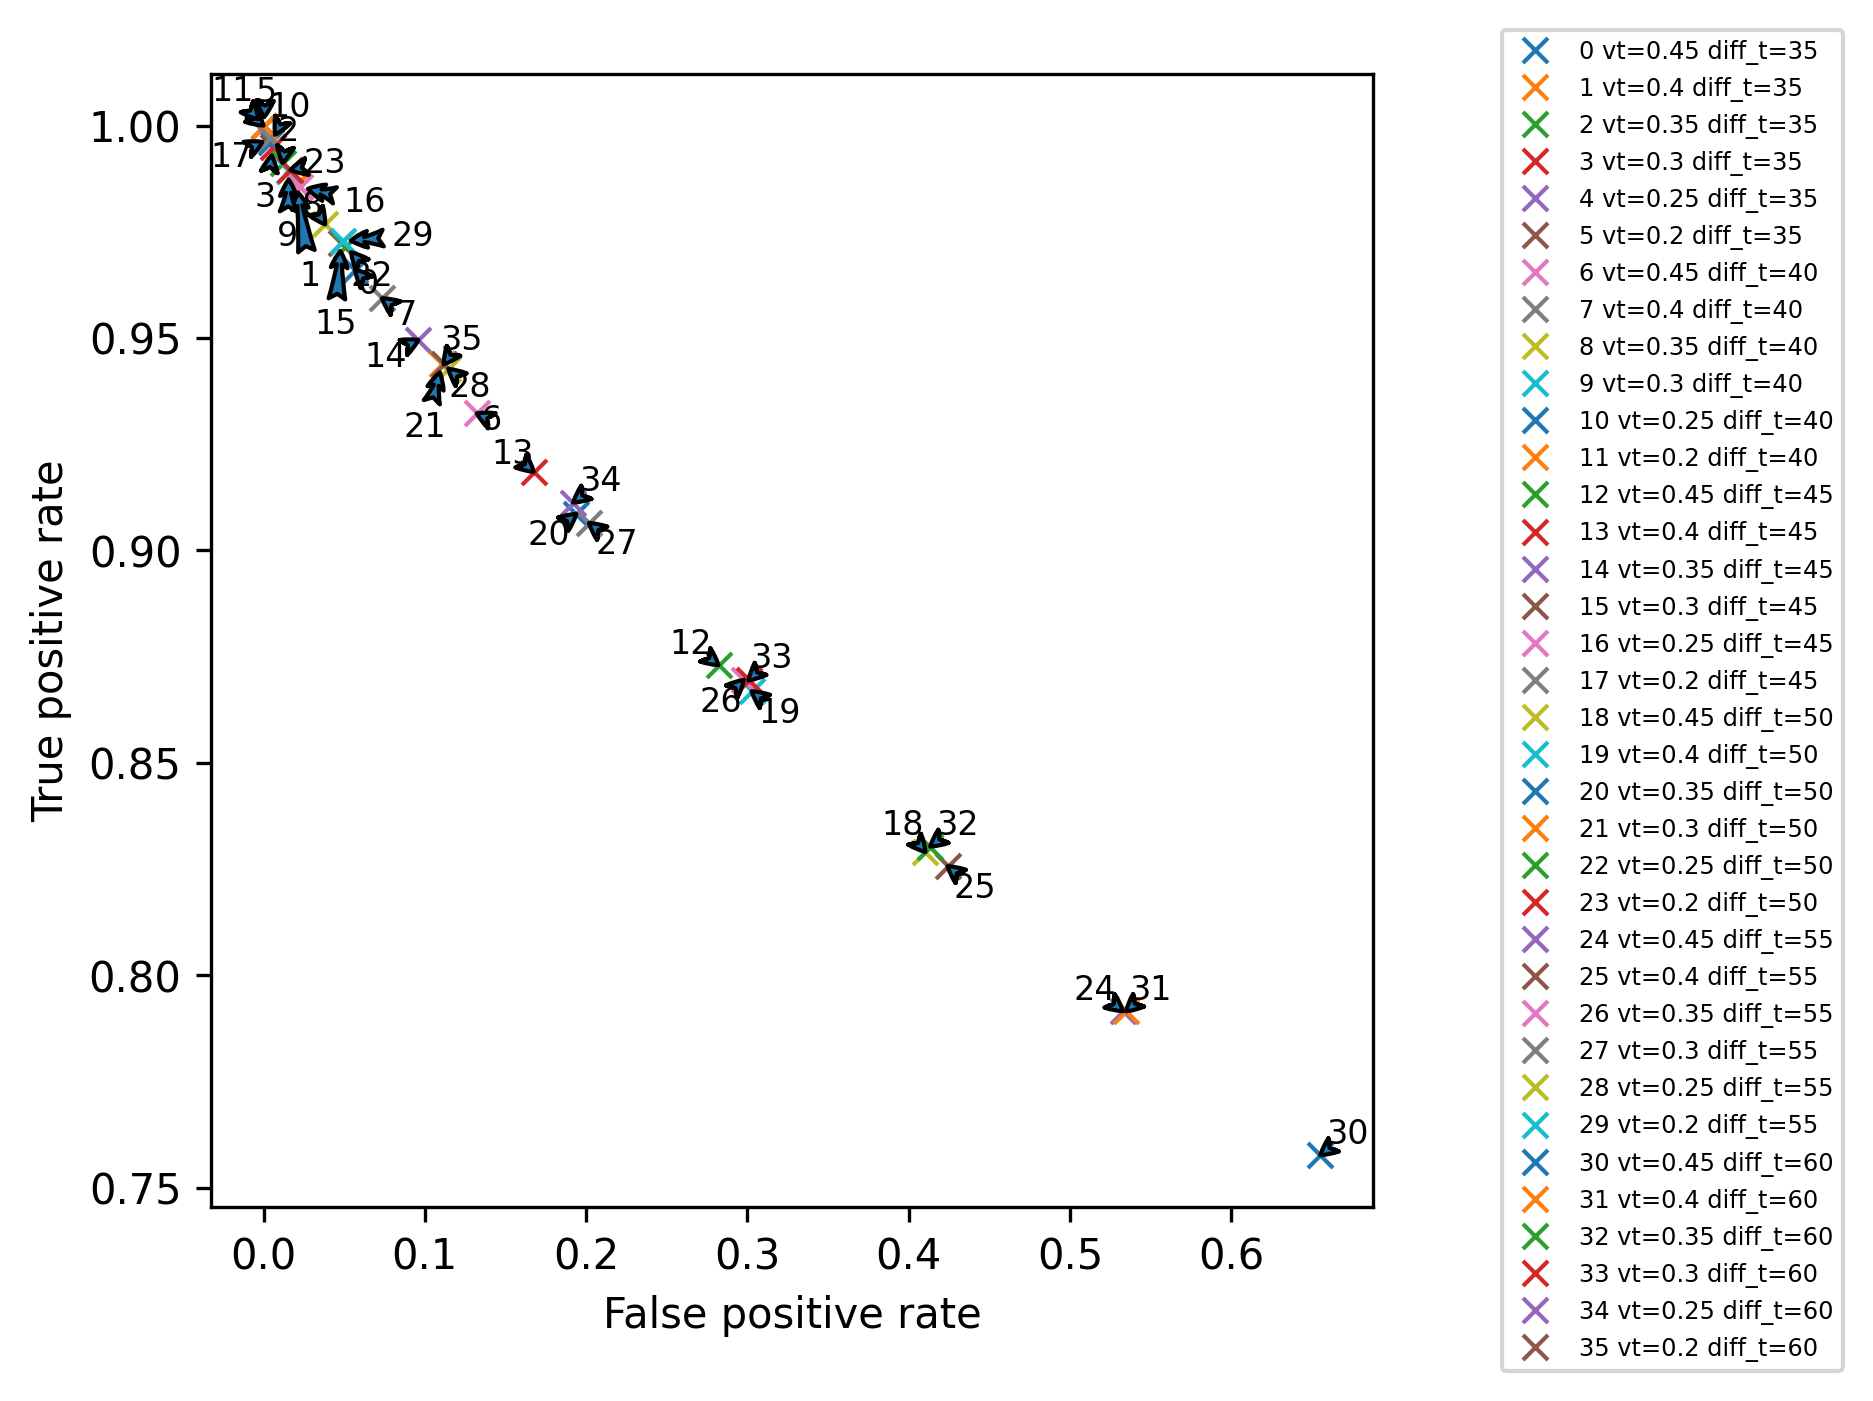

In [52]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties

tpr = [m.precision for m in metrics_list]
fpr = [1 - m.specificity for m in metrics_list]
# auc_1 = auc(fpr, tpr)
 
 
plt.figure(figsize=(5,5), dpi=300)
for f,p in zip(fpr,tpr):
    plt.plot(f, p, 'x')

# plt.scatter(fpr, tpr)

# for i, txt in enumerate(tpr):
#     plt.annotate(i, (fpr[i], tpr[i]))
    
texts = [plt.text(fpr[i], tpr[i], str(i), size=8) for i in range(len(fpr))]
adjust_text(texts, arrowprops={'arrowstyle' : 'fancy'}, expand_points=(1.3, 1.3))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

fontP = FontProperties()
fontP.set_size('xx-small')

plt.legend([row.replace('UFPR04-Cloudy', str(i)) for i,row in enumerate(row_names)], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop=fontP)
plt.show()

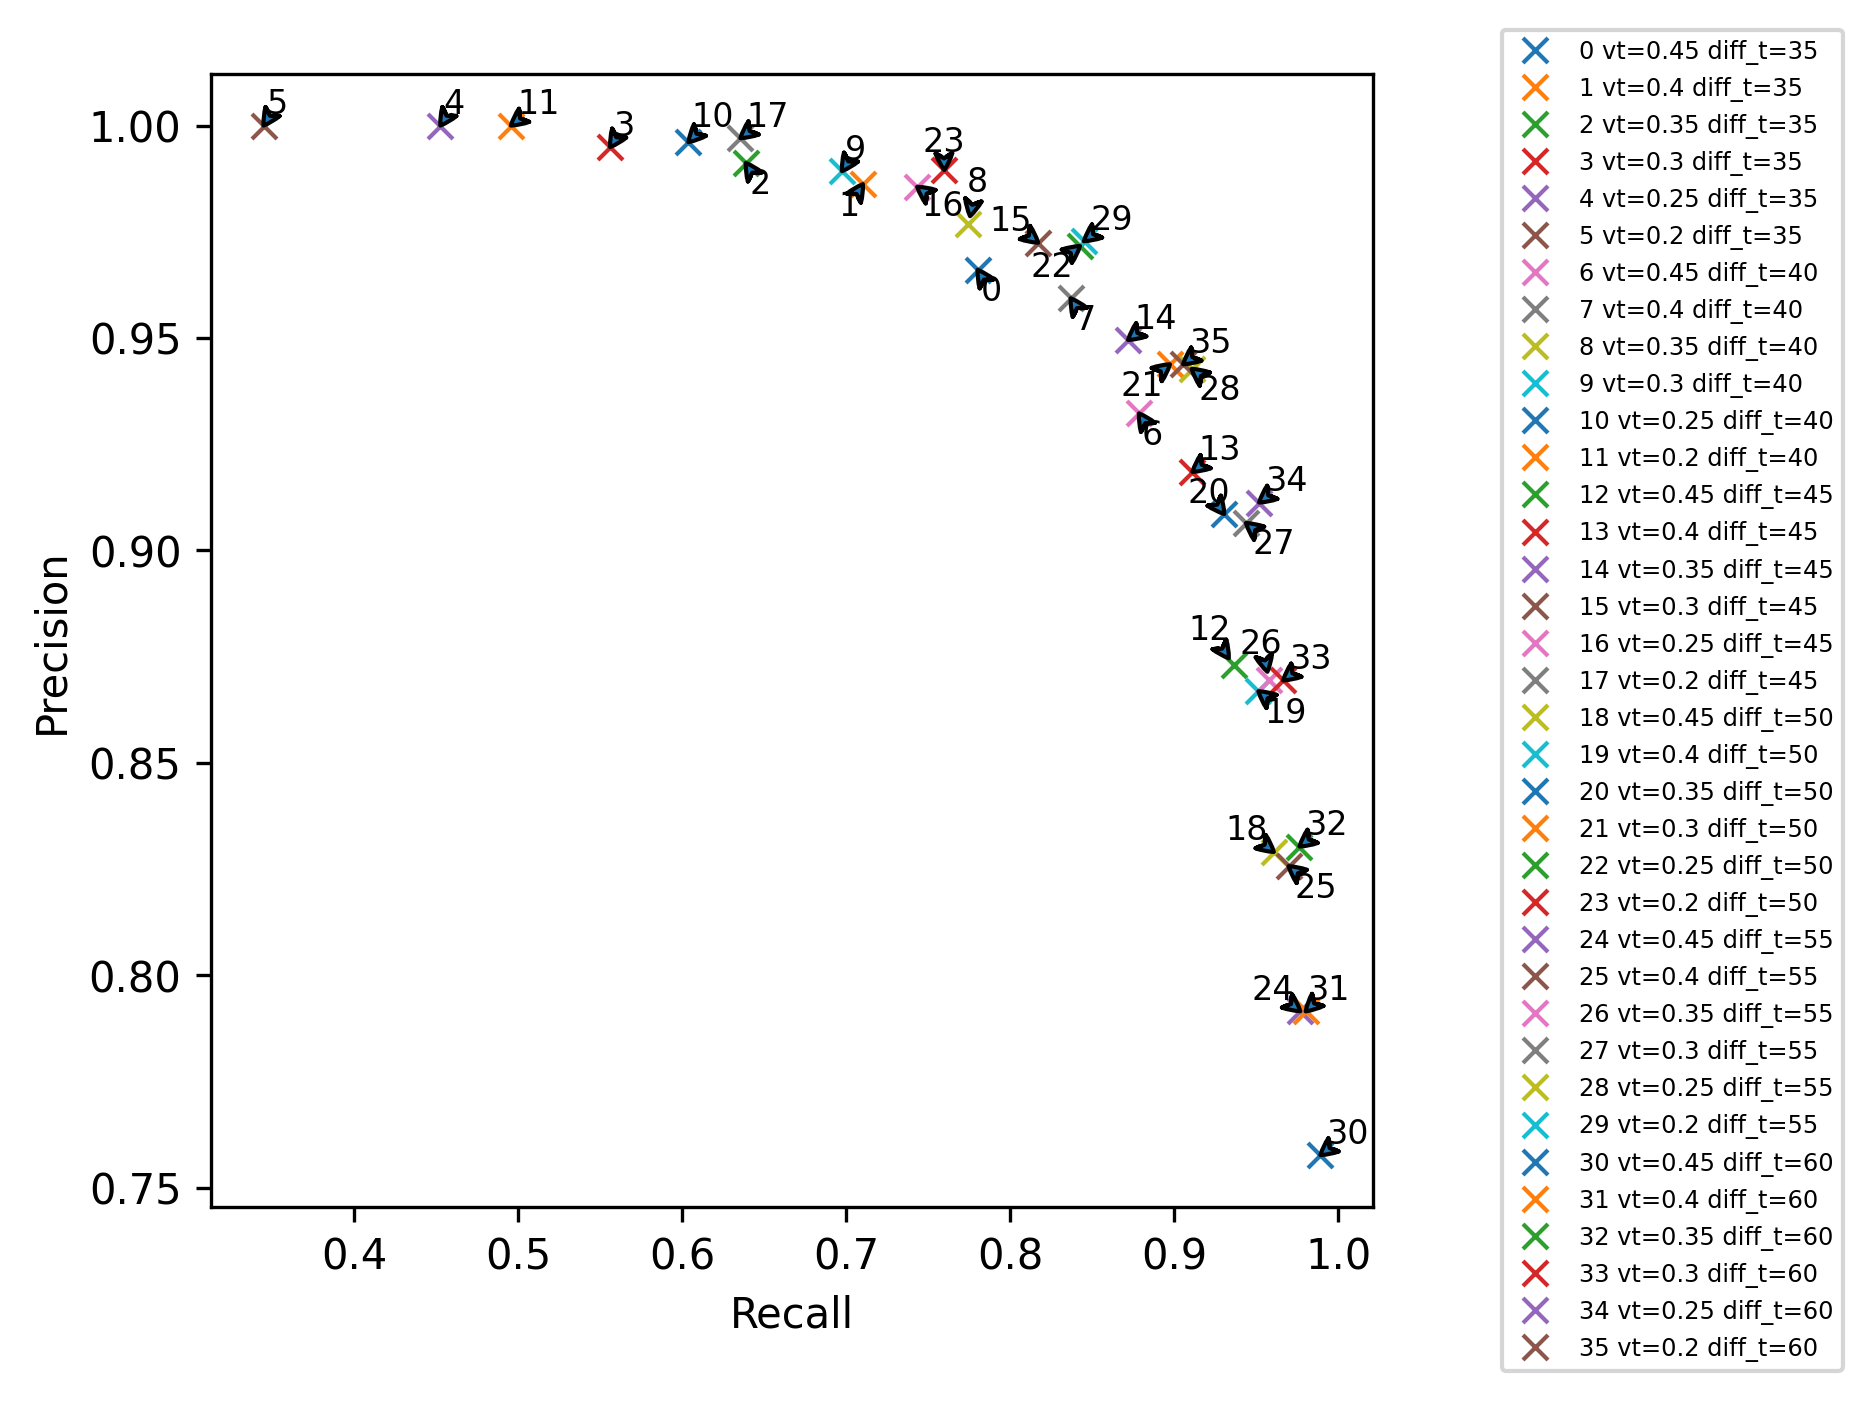

Testing  UFPR04-Sunny vt=0.45 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.50it/s]


Precision: 0.868
specificity: 0.910
Recall: 0.710
F1 Score: 0.781
Accuracy: 0.819


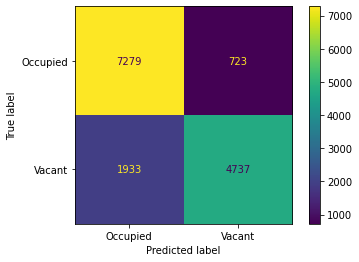

Testing  UFPR04-Sunny vt=0.45 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.26it/s]


Precision: 0.797
specificity: 0.831
Recall: 0.796
F1 Score: 0.796
Accuracy: 0.815


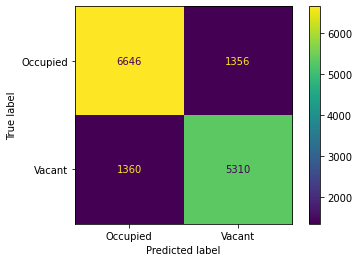

Testing  UFPR04-Sunny vt=0.45 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 20.15it/s]


Precision: 0.730
specificity: 0.736
Recall: 0.857
F1 Score: 0.789
Accuracy: 0.791


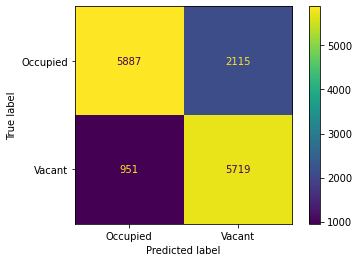

Testing  UFPR04-Sunny vt=0.45 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.92it/s]


Precision: 0.667
specificity: 0.626
Recall: 0.900
F1 Score: 0.767
Accuracy: 0.751


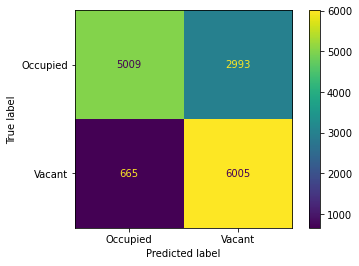

Testing  UFPR04-Sunny vt=0.45 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:24<00:00, 21.79it/s]


Precision: 0.607
specificity: 0.500
Recall: 0.927
F1 Score: 0.734
Accuracy: 0.694


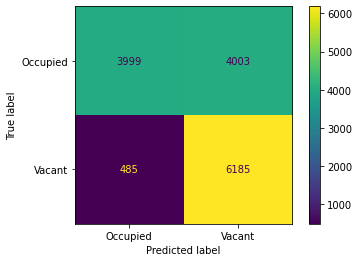

Testing  UFPR04-Sunny vt=0.45 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:22<00:00, 23.43it/s]


Precision: 0.563
specificity: 0.386
Recall: 0.949
F1 Score: 0.707
Accuracy: 0.642


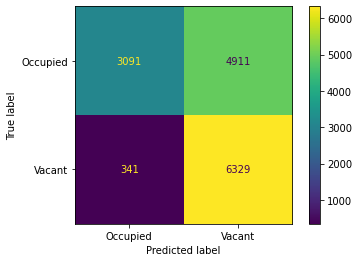

Testing  UFPR04-Sunny vt=0.4 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.53it/s]


Precision: 0.917
specificity: 0.949
Recall: 0.674
F1 Score: 0.777
Accuracy: 0.824


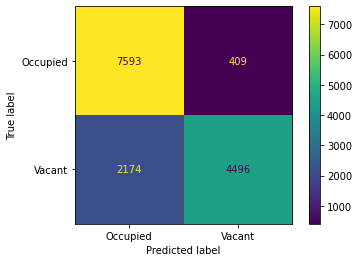

Testing  UFPR04-Sunny vt=0.4 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 20.09it/s]


Precision: 0.858
specificity: 0.895
Recall: 0.761
F1 Score: 0.806
Accuracy: 0.834


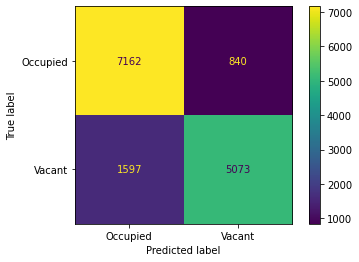

Testing  UFPR04-Sunny vt=0.4 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.45it/s]


Precision: 0.789
specificity: 0.815
Recall: 0.831
F1 Score: 0.809
Accuracy: 0.822


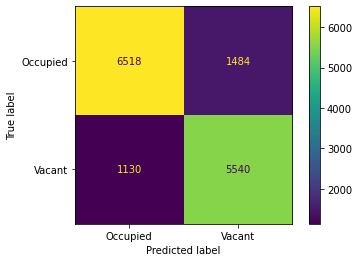

Testing  UFPR04-Sunny vt=0.4 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:24<00:00, 21.29it/s]


Precision: 0.729
specificity: 0.727
Recall: 0.882
F1 Score: 0.798
Accuracy: 0.797


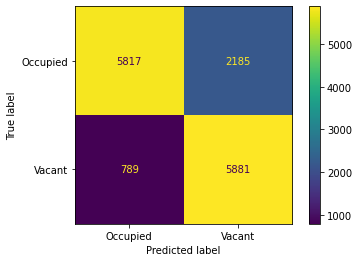

Testing  UFPR04-Sunny vt=0.4 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:23<00:00, 22.36it/s]


Precision: 0.665
specificity: 0.617
Recall: 0.914
F1 Score: 0.770
Accuracy: 0.752


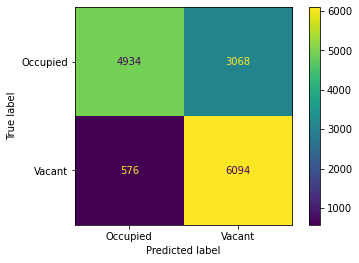

Testing  UFPR04-Sunny vt=0.4 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:22<00:00, 23.73it/s]


Precision: 0.608
specificity: 0.496
Recall: 0.939
F1 Score: 0.738
Accuracy: 0.697


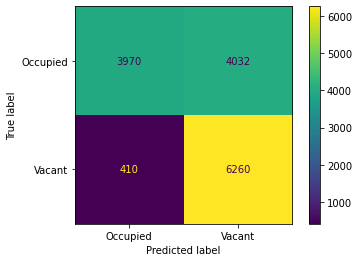

Testing  UFPR04-Sunny vt=0.35 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.88it/s]

Precision: 0.954
specificity: 0.974
Recall: 0.640
F1 Score: 0.766
Accuracy: 0.822


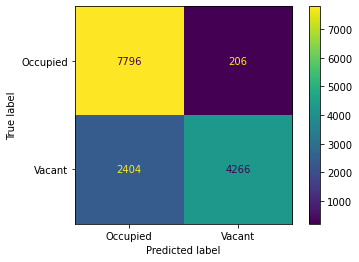

Testing  UFPR04-Sunny vt=0.35 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 19.86it/s]


Precision: 0.909
specificity: 0.939
Recall: 0.730
F1 Score: 0.810
Accuracy: 0.844


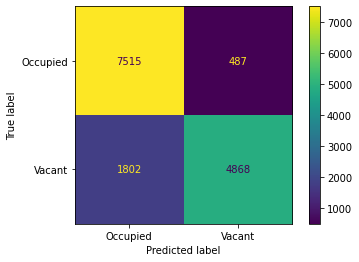

Testing  UFPR04-Sunny vt=0.35 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 20.03it/s]


Precision: 0.853
specificity: 0.885
Recall: 0.799
F1 Score: 0.825
Accuracy: 0.846


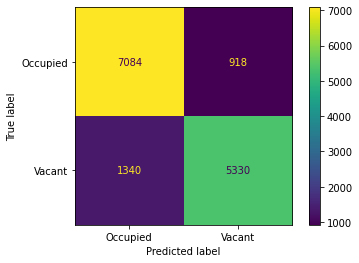

Testing  UFPR04-Sunny vt=0.35 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.82it/s]


Precision: 0.787
specificity: 0.806
Recall: 0.856
F1 Score: 0.820
Accuracy: 0.829


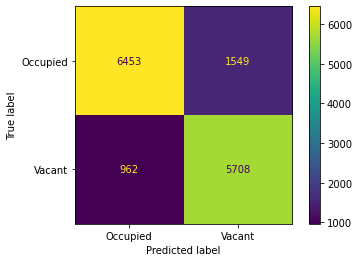

Testing  UFPR04-Sunny vt=0.35 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:23<00:00, 22.46it/s]


Precision: 0.729
specificity: 0.722
Recall: 0.898
F1 Score: 0.805
Accuracy: 0.802


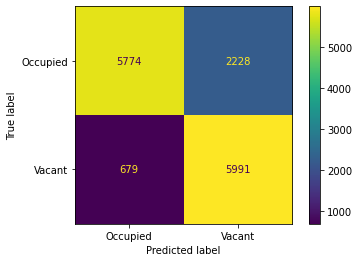

Testing  UFPR04-Sunny vt=0.35 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:21<00:00, 23.82it/s]


Precision: 0.665
specificity: 0.613
Recall: 0.924
F1 Score: 0.774
Accuracy: 0.754


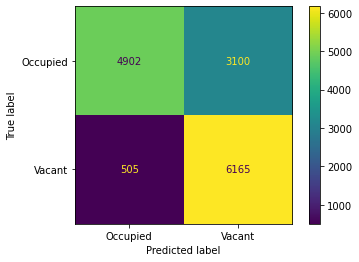

Testing  UFPR04-Sunny vt=0.3 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.70it/s]

Precision: 0.976
specificity: 0.988
Recall: 0.596
F1 Score: 0.740
Accuracy: 0.810


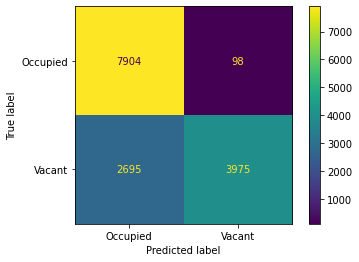

Testing  UFPR04-Sunny vt=0.3 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 20.06it/s]


Precision: 0.950
specificity: 0.970
Recall: 0.690
F1 Score: 0.800
Accuracy: 0.843


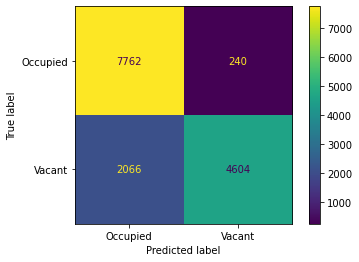

Testing  UFPR04-Sunny vt=0.3 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 19.71it/s]


Precision: 0.903
specificity: 0.932
Recall: 0.765
F1 Score: 0.828
Accuracy: 0.856


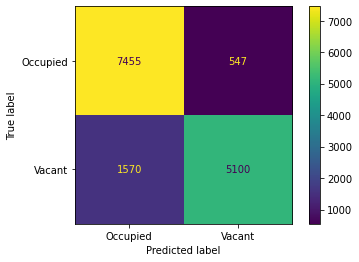

Testing  UFPR04-Sunny vt=0.3 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.93it/s]


Precision: 0.847
specificity: 0.876
Recall: 0.825
F1 Score: 0.836
Accuracy: 0.853


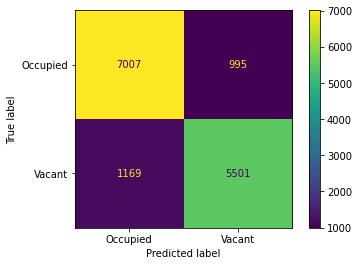

Testing  UFPR04-Sunny vt=0.3 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:23<00:00, 21.95it/s]


Precision: 0.786
specificity: 0.801
Recall: 0.875
F1 Score: 0.828
Accuracy: 0.835


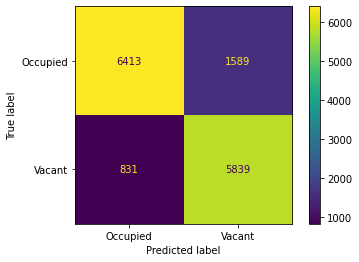

Testing  UFPR04-Sunny vt=0.3 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:22<00:00, 23.47it/s]


Precision: 0.725
specificity: 0.713
Recall: 0.907
F1 Score: 0.806
Accuracy: 0.801


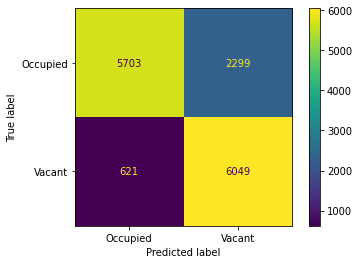

Testing  UFPR04-Sunny vt=0.25 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.43it/s]


Precision: 0.985
specificity: 0.993
Recall: 0.546
F1 Score: 0.703
Accuracy: 0.790


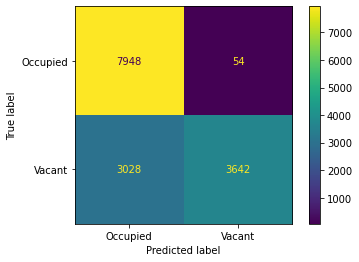

Testing  UFPR04-Sunny vt=0.25 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 19.90it/s]


Precision: 0.977
specificity: 0.987
Recall: 0.641
F1 Score: 0.774
Accuracy: 0.830


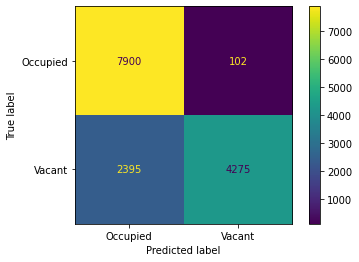

Testing  UFPR04-Sunny vt=0.25 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.23it/s]


Precision: 0.953
specificity: 0.970
Recall: 0.727
F1 Score: 0.825
Accuracy: 0.860


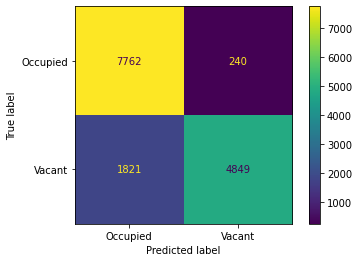

Testing  UFPR04-Sunny vt=0.25 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.49it/s]


Precision: 0.906
specificity: 0.932
Recall: 0.793
F1 Score: 0.846
Accuracy: 0.869


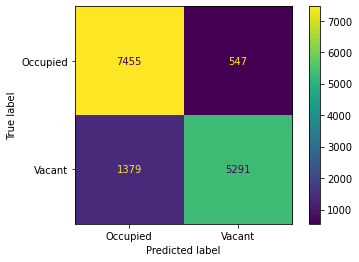

Testing  UFPR04-Sunny vt=0.25 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:24<00:00, 21.41it/s]


Precision: 0.848
specificity: 0.874
Recall: 0.843
F1 Score: 0.845
Accuracy: 0.860


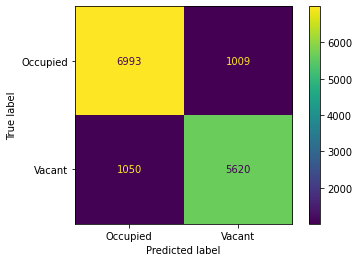

Testing  UFPR04-Sunny vt=0.25 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:22<00:00, 23.52it/s]


Precision: 0.788
specificity: 0.801
Recall: 0.886
F1 Score: 0.834
Accuracy: 0.840


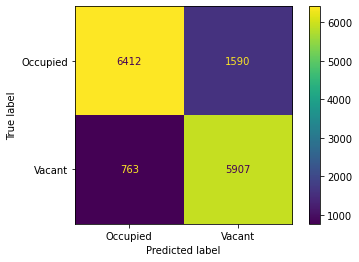

Testing  UFPR04-Sunny vt=0.2 diff_t=35
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.36it/s]


Precision: 0.993
specificity: 0.997
Recall: 0.482
F1 Score: 0.649
Accuracy: 0.763


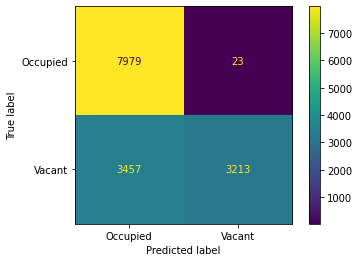

Testing  UFPR04-Sunny vt=0.2 diff_t=40
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 19.84it/s]


Precision: 0.987
specificity: 0.993
Recall: 0.593
F1 Score: 0.741
Accuracy: 0.811


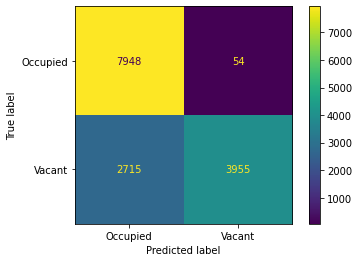

Testing  UFPR04-Sunny vt=0.2 diff_t=45
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:26<00:00, 19.74it/s]


Precision: 0.977
specificity: 0.987
Recall: 0.675
F1 Score: 0.799
Accuracy: 0.845


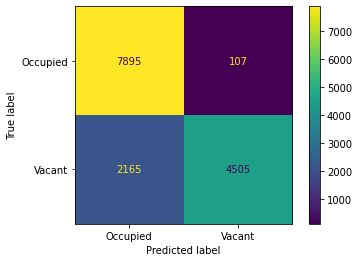

Testing  UFPR04-Sunny vt=0.2 diff_t=50
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:25<00:00, 20.64it/s]


Precision: 0.954
specificity: 0.970
Recall: 0.750
F1 Score: 0.840
Accuracy: 0.870


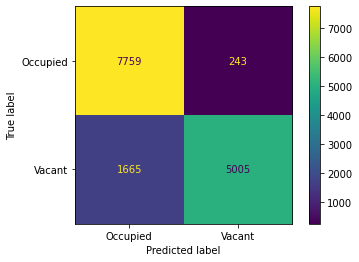

Testing  UFPR04-Sunny vt=0.2 diff_t=55
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:24<00:00, 21.74it/s]


Precision: 0.910
specificity: 0.934
Recall: 0.808
F1 Score: 0.856
Accuracy: 0.876


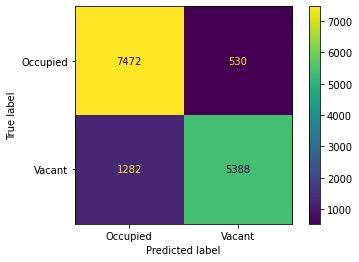

Testing  UFPR04-Sunny vt=0.2 diff_t=60
Selected 524 files
Processing 524 files with 16 workers


100%|██████████| 524/524 [00:22<00:00, 23.03it/s]


Precision: 0.854
specificity: 0.878
Recall: 0.855
F1 Score: 0.854
Accuracy: 0.867


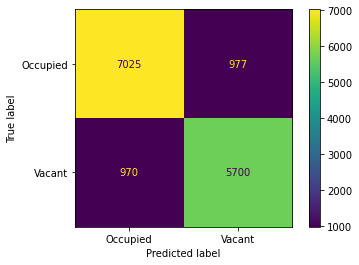

In [48]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=True)  # UFPR04
vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [35,40,45,50,55,60]
parking_id = 'UFPR04'
weather = 'Sunny'
 
metrics_dict_vt = test_vacant_threshold(parking_id, weather, PARAMS_UFPR04, diff_threshold_list, vacant_threshold_list)

In [67]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
file_to_write = open("metrics_dict_vt_UFPR05_Cloudy.pickle", "wb")
pickle.dump(metrics_dict_vt, file_to_write)

# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

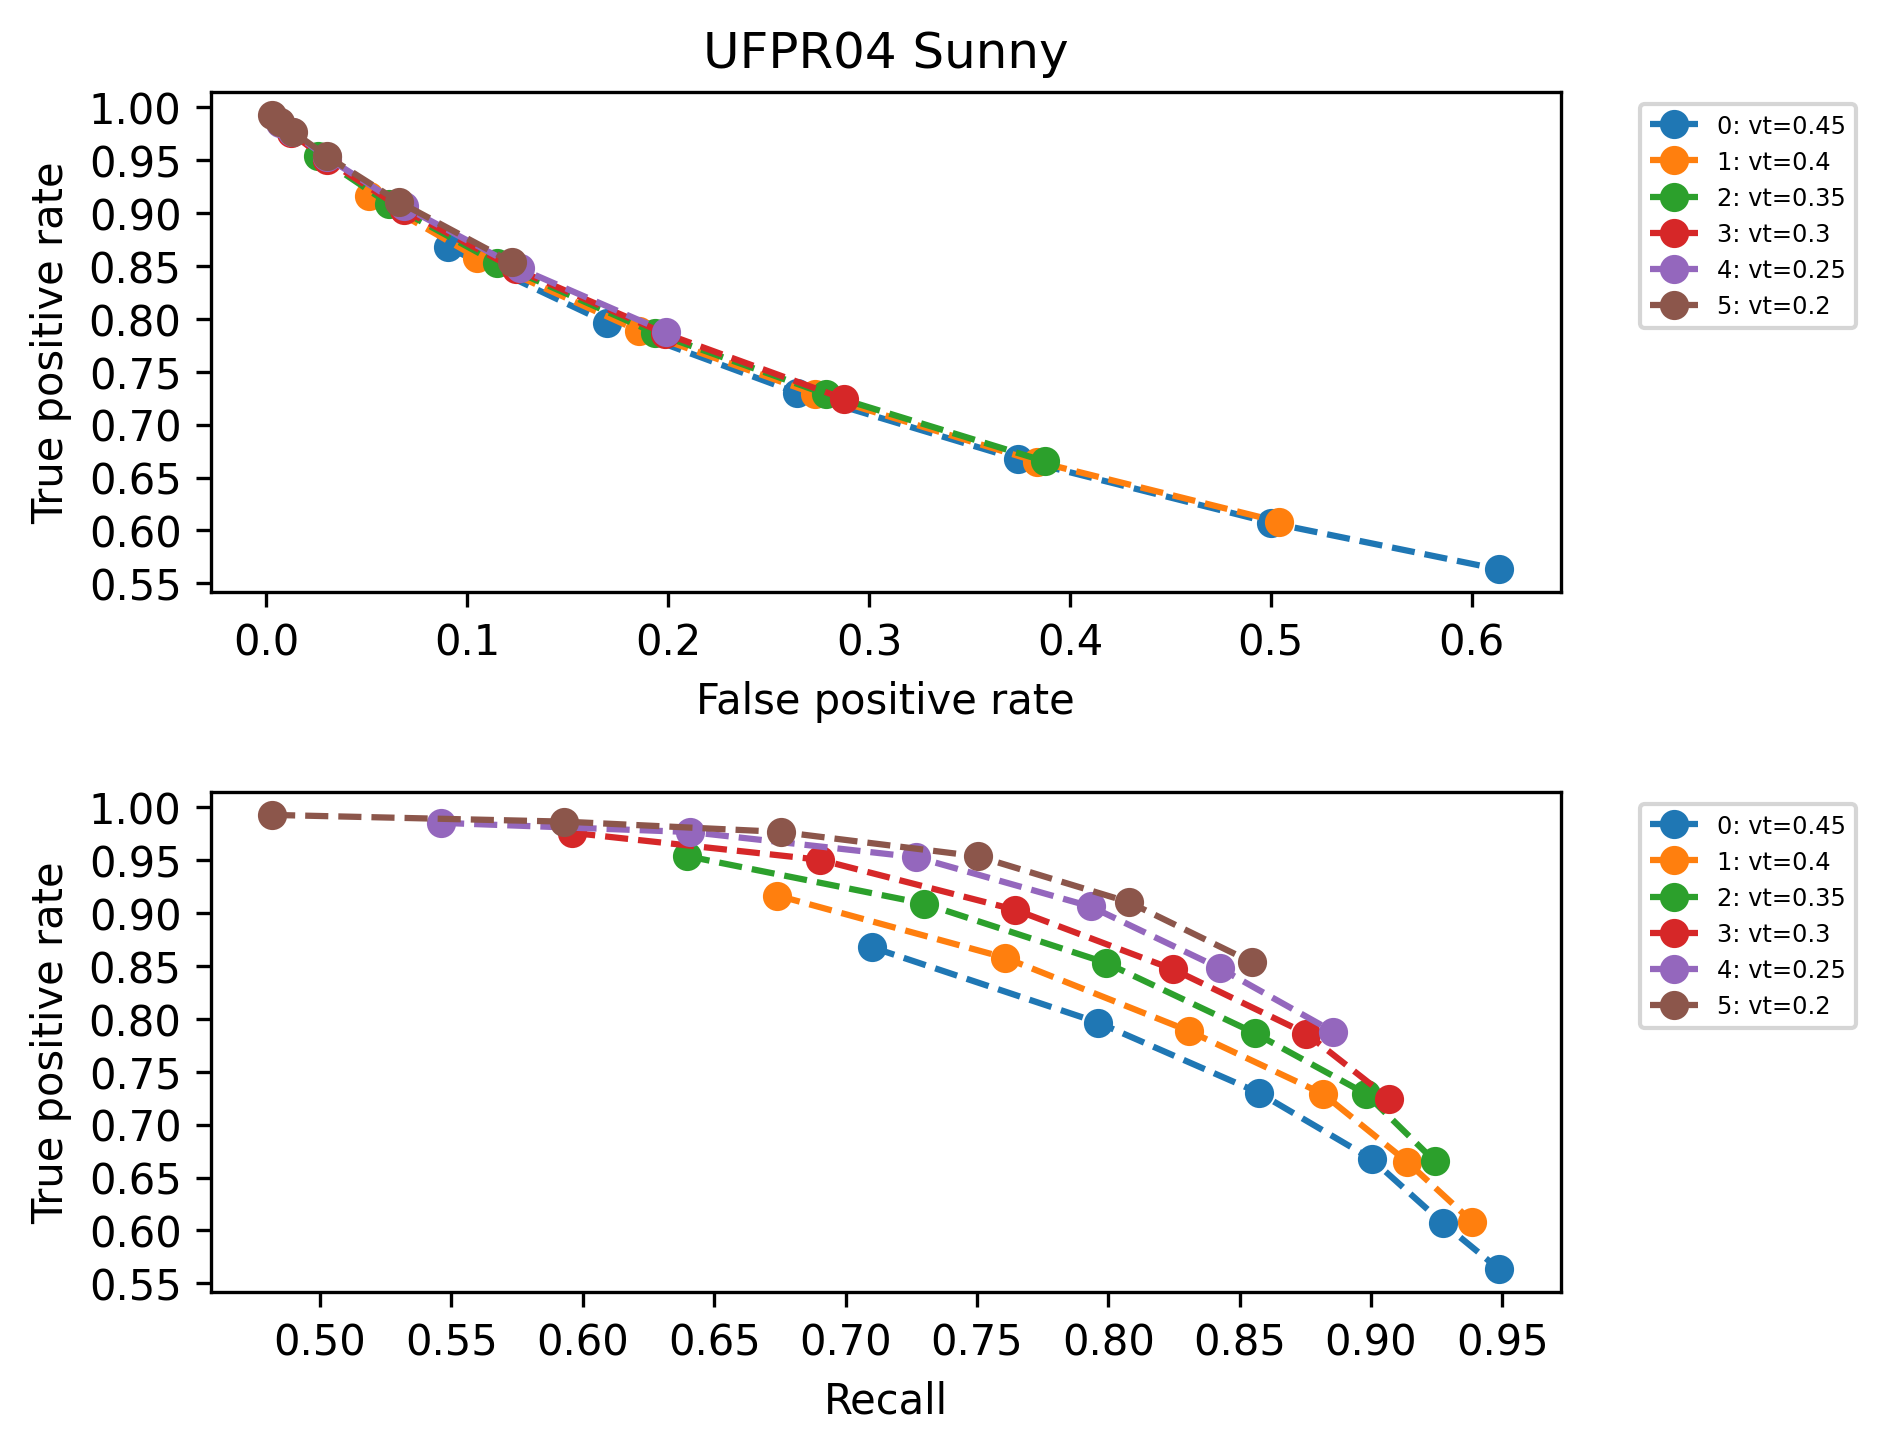

In [62]:
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
import pickle
from numpy import arange


# with open("output.pickle", 'rb') as handle:
#     metrics_dict_vt = pickle.load(handle)
    
        
fontP = FontProperties()
fontP.set_size('xx-small')

plt.figure(figsize=(5, 5), dpi=300)
index = 0
for vt, metrics_dict_diff in metrics_dict_vt.items():
    tpr_list = list()
    fpr_list = list()
    recall_list = list()
    for diff, metrics in metrics_dict_diff.items():
        tpr_list.append(metrics.precision)
        fpr_list.append(1 - metrics.specificity)
        recall_list.append(metrics.recall)

# auc_1 = auc(fpr, tpr)

    plt.subplot(2, 1, 1)
    li = zip(*[fpr_list, tpr_list])
    plt.plot(*zip(*li), linestyle='--', marker='o',
                label=f'{index}: vt={vt}')

    plt.subplot(2, 1, 2)
    li_recall = zip(*[recall_list, tpr_list])
    plt.plot(*zip(*li_recall), linestyle='--', marker='o',
                label=f'{index}: vt={vt}')
    

    
    index+=1

plt.subplot(2, 1, 1)
plt.title('UFPR04 Sunny')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks(arange(0, 1.05, 0.1))
plt.yticks(arange(0.5, 1.05, 0.05))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.plot(xy=(0,1),linestyle='--', marker='o', label='Perfect classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.subplot(2, 1, 2)
plt.xlabel('Recall')
plt.ylabel('True positive rate')

plt.xticks(arange(0, 1.05, 0.05))
plt.yticks(arange(0.5, 1.05, 0.05))
    
plt.plot(xy=(1,1), linestyle='--', marker='o',label='Perfect classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
plt.show()

# PerformanceMetricsProviderSklearn.show_precision_recall(metrics_dict_vt)

# UFPR05

Testing  UFPR05-Rainy vt=0.45 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.52it/s]


Precision: 0.802
specificity: 0.869
Recall: 0.990
F1 Score: 0.886
Accuracy: 0.911


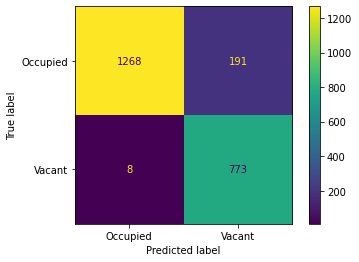

Testing  UFPR05-Rainy vt=0.45 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 11.17it/s]

Precision: 0.686
specificity: 0.756
Recall: 0.997
F1 Score: 0.813
Accuracy: 0.840


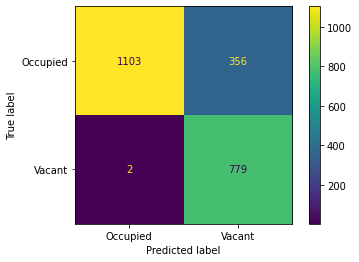

Testing  UFPR05-Rainy vt=0.45 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.84it/s]

Precision: 0.586
specificity: 0.623
Recall: 0.999
F1 Score: 0.739
Accuracy: 0.754


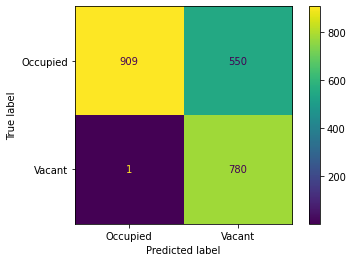

Testing  UFPR05-Rainy vt=0.45 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.23it/s]

Precision: 0.500
specificity: 0.465
Recall: 1.000
F1 Score: 0.667
Accuracy: 0.651


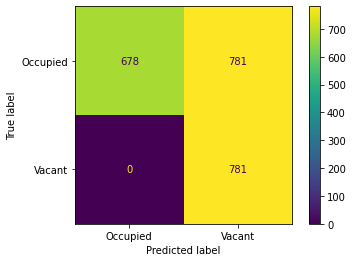

Testing  UFPR05-Rainy vt=0.45 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.63it/s]

Precision: 0.433
specificity: 0.300
Recall: 1.000
F1 Score: 0.605
Accuracy: 0.544


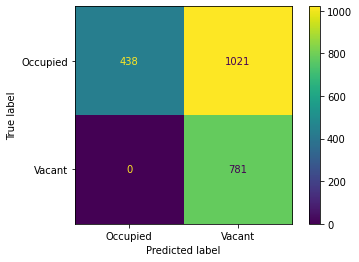

Testing  UFPR05-Rainy vt=0.45 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.74it/s]


Precision: 0.390
specificity: 0.162
Recall: 1.000
F1 Score: 0.561
Accuracy: 0.454


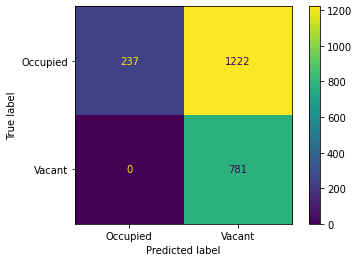

Testing  UFPR05-Rainy vt=0.4 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.47it/s]


Precision: 0.856
specificity: 0.911
Recall: 0.987
F1 Score: 0.917
Accuracy: 0.938


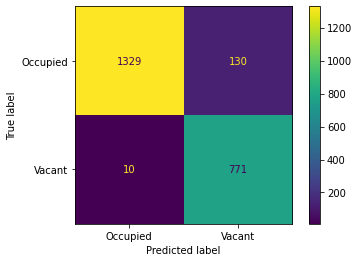

Testing  UFPR05-Rainy vt=0.4 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.28it/s]


Precision: 0.770
specificity: 0.841
Recall: 0.996
F1 Score: 0.869
Accuracy: 0.895


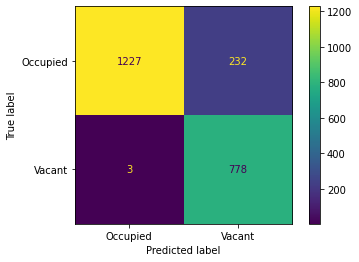

Testing  UFPR05-Rainy vt=0.4 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.06it/s]


Precision: 0.668
specificity: 0.734
Recall: 0.999
F1 Score: 0.800
Accuracy: 0.826


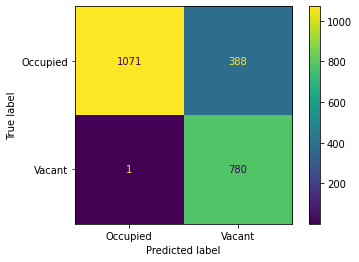

Testing  UFPR05-Rainy vt=0.4 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.35it/s]


Precision: 0.567
specificity: 0.592
Recall: 0.999
F1 Score: 0.724
Accuracy: 0.734


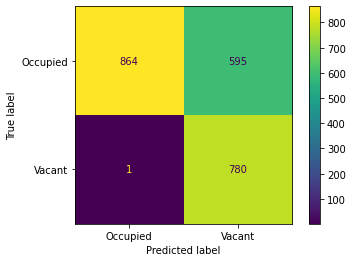

Testing  UFPR05-Rainy vt=0.4 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.62it/s]


Precision: 0.495
specificity: 0.454
Recall: 1.000
F1 Score: 0.662
Accuracy: 0.645


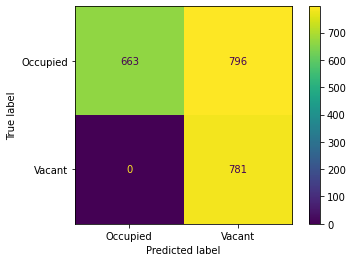

Testing  UFPR05-Rainy vt=0.4 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 11.06it/s]

Precision: 0.434
specificity: 0.301
Recall: 1.000
F1 Score: 0.605
Accuracy: 0.545


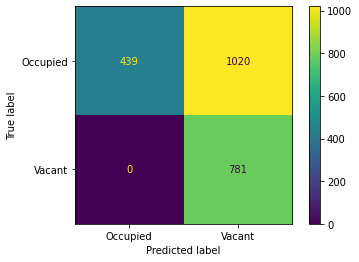

Testing  UFPR05-Rainy vt=0.35 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.06it/s]


Precision: 0.884
specificity: 0.931
Recall: 0.980
F1 Score: 0.930
Accuracy: 0.948


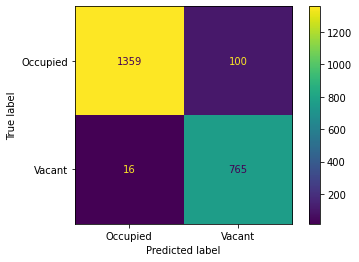

Testing  UFPR05-Rainy vt=0.35 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.29it/s]


Precision: 0.830
specificity: 0.891
Recall: 0.991
F1 Score: 0.903
Accuracy: 0.926


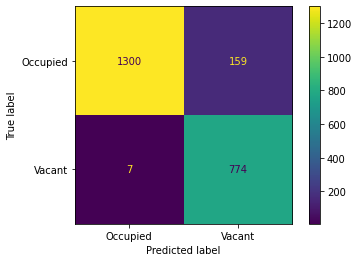

Testing  UFPR05-Rainy vt=0.35 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.98it/s]


Precision: 0.743
specificity: 0.815
Recall: 0.997
F1 Score: 0.851
Accuracy: 0.879


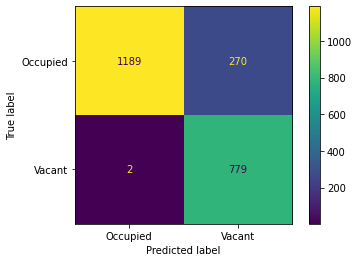

Testing  UFPR05-Rainy vt=0.35 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.35it/s]

Precision: 0.645
specificity: 0.705
Recall: 0.999
F1 Score: 0.784
Accuracy: 0.808


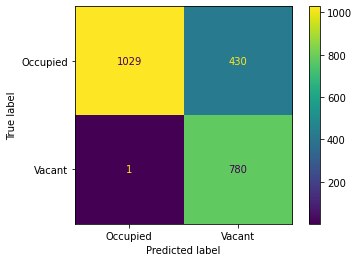

Testing  UFPR05-Rainy vt=0.35 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.54it/s]


Precision: 0.554
specificity: 0.570
Recall: 0.999
F1 Score: 0.713
Accuracy: 0.719


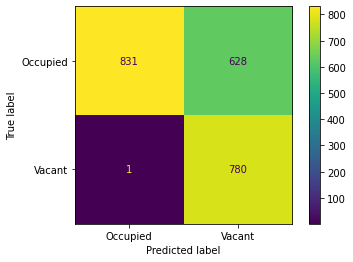

Testing  UFPR05-Rainy vt=0.35 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.76it/s]


Precision: 0.485
specificity: 0.432
Recall: 1.000
F1 Score: 0.654
Accuracy: 0.630


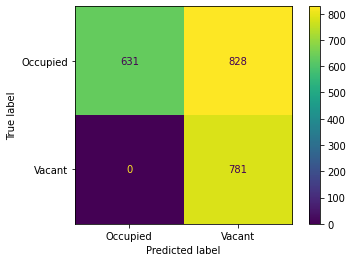

Testing  UFPR05-Rainy vt=0.3 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.57it/s]


Precision: 0.920
specificity: 0.955
Recall: 0.976
F1 Score: 0.947
Accuracy: 0.962


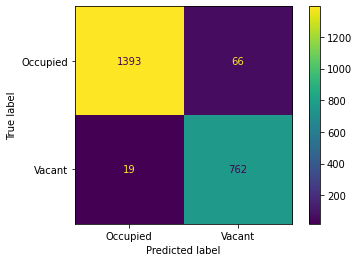

Testing  UFPR05-Rainy vt=0.3 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.27it/s]

Precision: 0.876
specificity: 0.925
Recall: 0.987
F1 Score: 0.928
Accuracy: 0.947


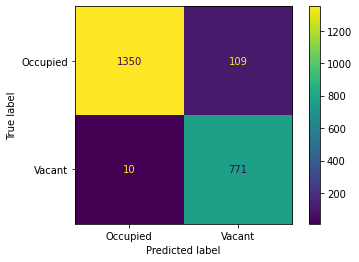

Testing  UFPR05-Rainy vt=0.3 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.97it/s]


Precision: 0.817
specificity: 0.881
Recall: 0.996
F1 Score: 0.898
Accuracy: 0.921


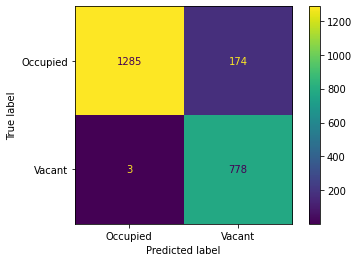

Testing  UFPR05-Rainy vt=0.3 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.30it/s]


Precision: 0.729
specificity: 0.801
Recall: 0.999
F1 Score: 0.843
Accuracy: 0.870


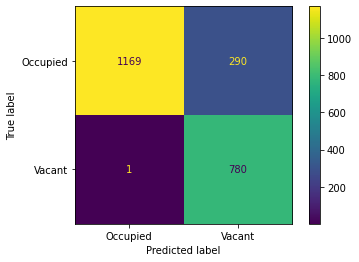

Testing  UFPR05-Rainy vt=0.3 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.59it/s]


Precision: 0.629
specificity: 0.685
Recall: 0.999
F1 Score: 0.772
Accuracy: 0.794


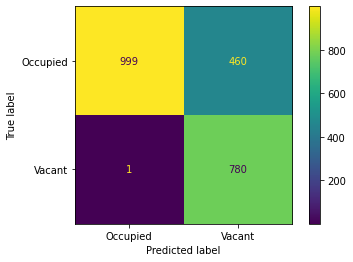

Testing  UFPR05-Rainy vt=0.3 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.71it/s]


Precision: 0.543
specificity: 0.550
Recall: 1.000
F1 Score: 0.704
Accuracy: 0.707


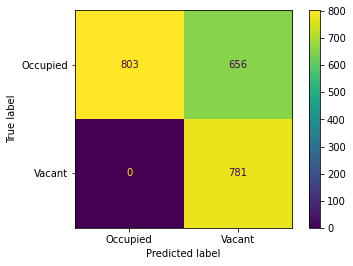

Testing  UFPR05-Rainy vt=0.25 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.57it/s]


Precision: 0.944
specificity: 0.969
Recall: 0.972
F1 Score: 0.958
Accuracy: 0.970


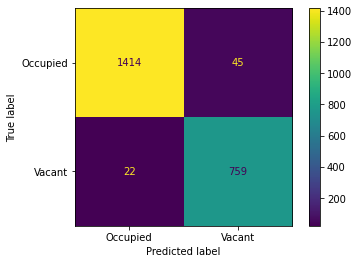

Testing  UFPR05-Rainy vt=0.25 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 11.19it/s]


Precision: 0.907
specificity: 0.946
Recall: 0.985
F1 Score: 0.944
Accuracy: 0.959


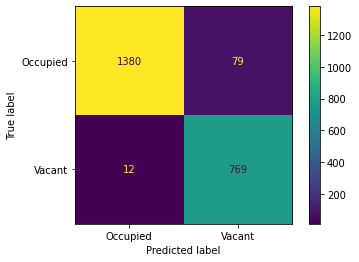

Testing  UFPR05-Rainy vt=0.25 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.94it/s]


Precision: 0.859
specificity: 0.913
Recall: 0.994
F1 Score: 0.922
Accuracy: 0.941


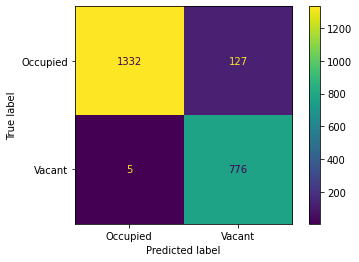

Testing  UFPR05-Rainy vt=0.25 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.31it/s]


Precision: 0.808
specificity: 0.873
Recall: 0.997
F1 Score: 0.893
Accuracy: 0.917


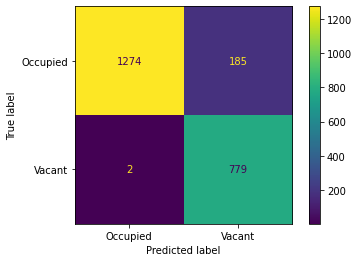

Testing  UFPR05-Rainy vt=0.25 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.72it/s]

Precision: 0.712
specificity: 0.783
Recall: 0.999
F1 Score: 0.831
Accuracy: 0.858


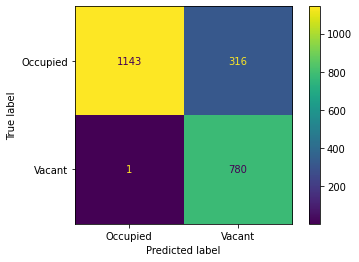

Testing  UFPR05-Rainy vt=0.25 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.75it/s]


Precision: 0.616
specificity: 0.666
Recall: 1.000
F1 Score: 0.762
Accuracy: 0.783


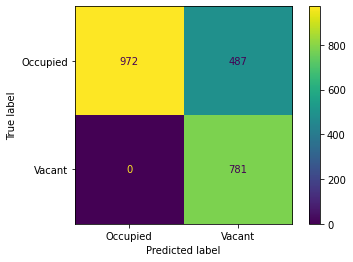

Testing  UFPR05-Rainy vt=0.2 diff_t=35
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 10.44it/s]


Precision: 0.965
specificity: 0.981
Recall: 0.955
F1 Score: 0.960
Accuracy: 0.972


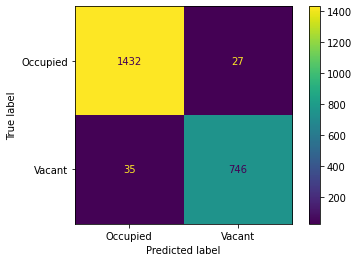

Testing  UFPR05-Rainy vt=0.2 diff_t=40
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:05<00:00, 11.16it/s]


Precision: 0.936
specificity: 0.964
Recall: 0.974
F1 Score: 0.955
Accuracy: 0.968


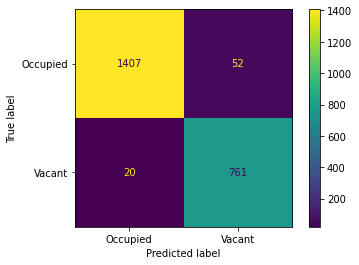

Testing  UFPR05-Rainy vt=0.2 diff_t=45
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 11.99it/s]

Precision: 0.901
specificity: 0.942
Recall: 0.990
F1 Score: 0.943
Accuracy: 0.958


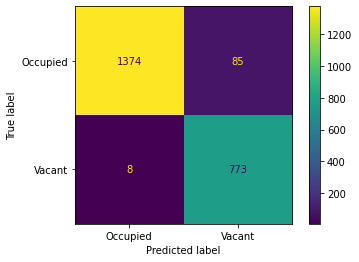

Testing  UFPR05-Rainy vt=0.2 diff_t=50
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.13it/s]


Precision: 0.851
specificity: 0.907
Recall: 0.996
F1 Score: 0.918
Accuracy: 0.938


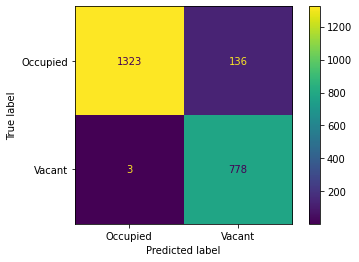

Testing  UFPR05-Rainy vt=0.2 diff_t=55
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.64it/s]


Precision: 0.804
specificity: 0.870
Recall: 0.999
F1 Score: 0.891
Accuracy: 0.915


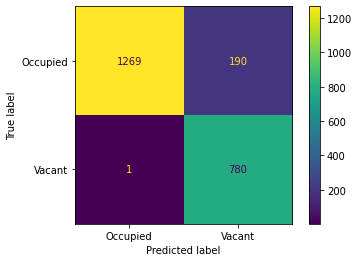

Testing  UFPR05-Rainy vt=0.2 diff_t=60
Selected 56 files
Processing 56 files with 16 workers


100%|██████████| 56/56 [00:04<00:00, 12.64it/s]


Precision: 0.710
specificity: 0.781
Recall: 0.999
F1 Score: 0.830
Accuracy: 0.857


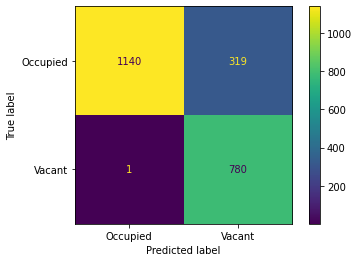

In [12]:
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, median_k=3, bw_size=20, show_imshow=False)
vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [35,40,45,50,55,60]
parking_id = 'UFPR05'

for weather in ['Rainy']:
    metrics_dict_vt = test_vacant_threshold(parking_id, weather, PARAMS_UFPR05, diff_threshold_list, vacant_threshold_list)
    # Saving the objects:
    file_to_write = open(f"metrics_dict_vt_{parking_id}_{weather}.pickle", "wb")
    pickle.dump(metrics_dict_vt, file_to_write)
 


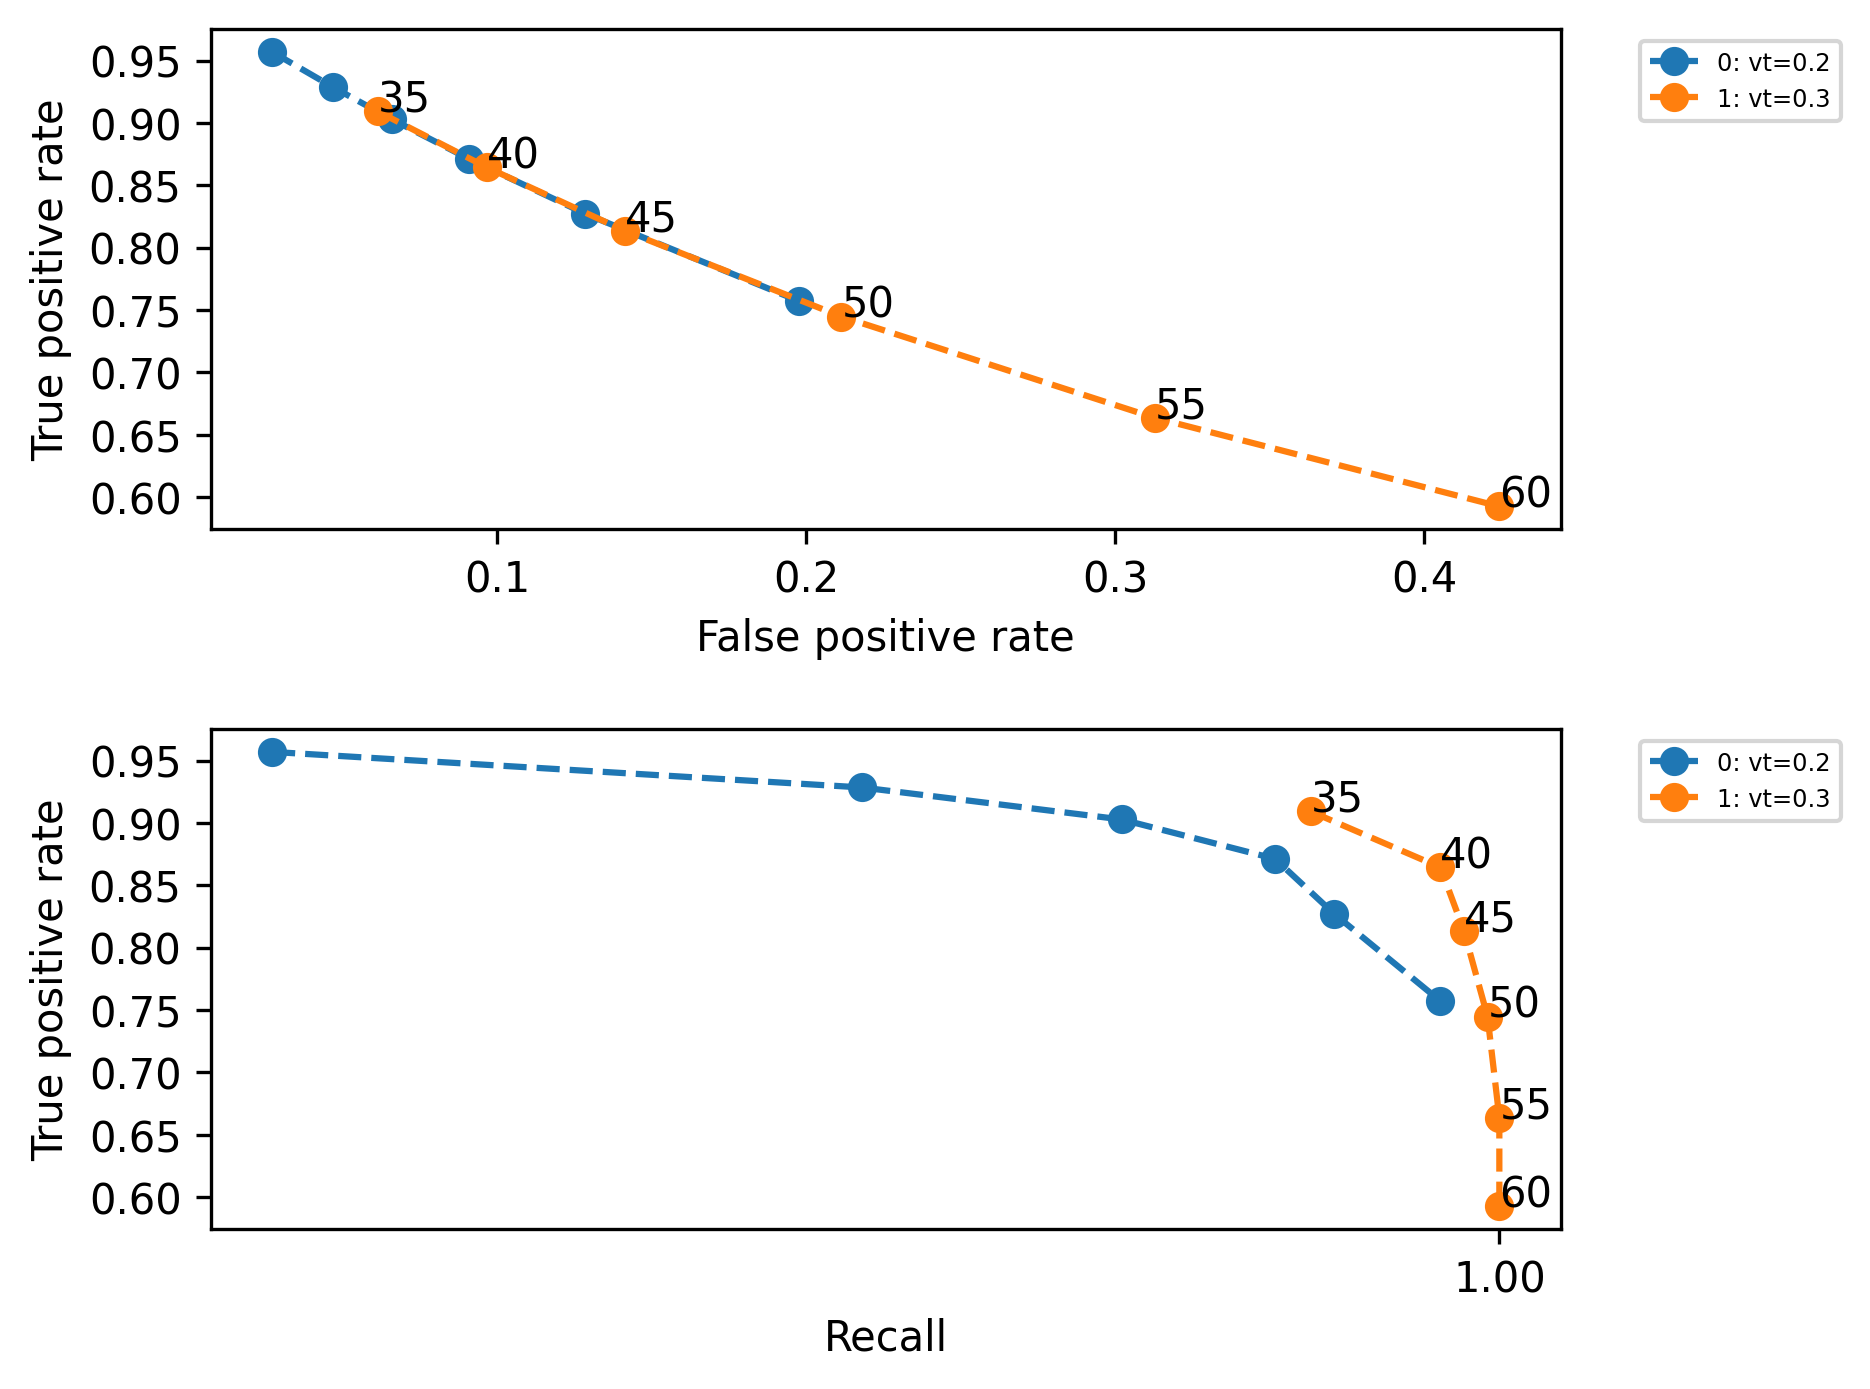

In [7]:
import pickle
with open("metrics_dict_vt_UFPR05_Cloudy.pickle", 'rb') as handle:
    metrics_dict_vt_UFPR05_Cloudy = pickle.load(handle)
    
a[0.3] = metrics_dict_vt_UFPR05_Cloudy[0.3]
PerformanceMetricsProviderSklearn.show_tpr_fpr(a, show_diff=True)



{0.45: {35: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f06f2fa0>,
  40: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f07166a0>,
  45: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f24915e0>,
  50: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f245df40>,
  55: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f24866d0>,
  60: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f2486700>},
 0.4: {35: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f24864c0>,
  40: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f2486910>,
  45: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f2486dc0>,
  50: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f2486190>,
  55: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f2486820>,
  60: <src.metrics.entity.PerformanceMetrics.PerformanceMetrics at 0x165f24